In [1]:
import cv2 as cv
import pickle
import csv

import os

import shutil
import warnings
import platform
from glob import glob
from itertools import chain
from collections import Counter
from dataclasses import dataclass
 
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
# from sklearn.utils.class_weight import compute_class_weight
 
# Next, we have our usual torch and torchvision imports.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
 
import torchvision
import torchvision.transforms as TF
from torchvision.utils import make_grid
from torchvision.ops import sigmoid_focal_loss
 
# Importing lighting along with a built-in callback it provides.
import lightning.pytorch as pl
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
 
# Importing torchmetrics modular and functional evaluation implementations.
from torchmetrics import MeanMetric
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy
 
# To print model summary.
from torchinfo import summary

import json

/home/noeyiue/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Handle data

In [2]:
annotation_path = '/home/noeyiue/cpe/ICSEC/annotation/update_260727.csv'
df = pd.read_csv(annotation_path, index_col ="image_name")
df

,id,group_id,image_data,is_appear_filter,is_filter,ethnicity,age,gender,hair_length,upper_body_length,...,upper_body_type,lower_body_length,lower_body_color,lower_body_type,footwear,backpack,bag,glasses,hat,mask
image_name,,,,,,,,,,,,,,,,,,,,,
outdoor_group651_Ch12_CH 12_100000.avi_4.jpg,48,651,binary data,True,True,Mongoloid,Adult,Male,Short,Short,...,Other,Short,Black,Trousers&Shorts,Sandals,No,No,No,No,No
outdoor_group21_Ch12_CH 12_150000.avi_2.jpg,66,21,binary data,True,True,Unsure,Adult,Female,Long,Short,...,Other,Long,Other,Trousers&Shorts,Sandals,No,No,No,No,No
outdoor_group1628_Ch12_CH 12_090000.avi.jpg,43,1628,binary data,True,True,Caucasoid,Young,Female,Long,NaN,...,Tanktop,Long,Blue,Trousers&Shorts,Sandals,No,Yes,Normal,No,No
outdoor_group172_Ch12_CH 12_170358.avi.jpg,51,172,binary data,True,True,Mongoloid,Adult,Male,Short,Short,...,Tshirt,Short,Other,Trousers&Shorts,Sandals,No,Yes,No,Yes,No
outdoor_group265_Ch12_CH 12_170358.avi_1.jpg,58,265,binary data,True,True,Mongoloid,Adult,Male,Bald,Short,...,Tshirt,Long,Black,Trousers&Shorts,Sandals,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
outdoor_group5041_Ch12_CH 12_130000 (1).avi_1041_8.jpg,10041,5041,binary data,True,True,Unsure,Adult,Female,Short,Short,...,Tshirt,Short,Brown,Trousers&Shorts,Shoes,No,No,No,No,No
outdoor_group5137_Ch12_CH 12_140000.avi_1137_8.jpg,9484,5137,binary data,True,True,Unsure,Adult,Male,Short,Short,...,Polo,Short,Blue,Trousers&Shorts,Sandals,No,No,No,No,No
outdoor_group4729_Ch12_CH 12_170000.avi_729_8.jpg,11271,4729,binary data,True,True,Mongoloid,Adult,Male,Short,Short,...,Tshirt,Long,Black,Trousers&Shorts,Sandals,No,No,No,No,No


In [3]:
# Define relevant columns
relevant_columns = [
    'ethnicity', 'age', 'gender', 'hair_length', 'upper_body_length', 'upper_body_color','upper_body_type',
    'lower_body_length', 'lower_body_color', 'lower_body_type',
    'footwear', 'backpack', 'bag', 'glasses', 'hat', 'mask'
]
df = df[relevant_columns]
df

,ethnicity,age,gender,hair_length,upper_body_length,upper_body_color,upper_body_type,lower_body_length,lower_body_color,lower_body_type,footwear,backpack,bag,glasses,hat,mask
image_name,,,,,,,,,,,,,,,,
outdoor_group651_Ch12_CH 12_100000.avi_4.jpg,Mongoloid,Adult,Male,Short,Short,Red,Other,Short,Black,Trousers&Shorts,Sandals,No,No,No,No,No
outdoor_group21_Ch12_CH 12_150000.avi_2.jpg,Unsure,Adult,Female,Long,Short,White,Other,Long,Other,Trousers&Shorts,Sandals,No,No,No,No,No
outdoor_group1628_Ch12_CH 12_090000.avi.jpg,Caucasoid,Young,Female,Long,NaN,Purple,Tanktop,Long,Blue,Trousers&Shorts,Sandals,No,Yes,Normal,No,No
outdoor_group172_Ch12_CH 12_170358.avi.jpg,Mongoloid,Adult,Male,Short,Short,White,Tshirt,Short,Other,Trousers&Shorts,Sandals,No,Yes,No,Yes,No
outdoor_group265_Ch12_CH 12_170358.avi_1.jpg,Mongoloid,Adult,Male,Bald,Short,Green,Tshirt,Long,Black,Trousers&Shorts,Sandals,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
outdoor_group5041_Ch12_CH 12_130000 (1).avi_1041_8.jpg,Unsure,Adult,Female,Short,Short,Black,Tshirt,Short,Brown,Trousers&Shorts,Shoes,No,No,No,No,No
outdoor_group5137_Ch12_CH 12_140000.avi_1137_8.jpg,Unsure,Adult,Male,Short,Short,White,Polo,Short,Blue,Trousers&Shorts,Sandals,No,No,No,No,No
outdoor_group4729_Ch12_CH 12_170000.avi_729_8.jpg,Mongoloid,Adult,Male,Short,Short,Black,Tshirt,Long,Black,Trousers&Shorts,Sandals,No,No,No,No,No


In [4]:
annotation_path = '/home/noeyiue/cpe/ICSEC/annotation/v1_data_26-724.csv'
second_df = pd.read_csv(annotation_path, index_col ="image_name")
second_df

,ethnicity,age,gender,hair_length,upper_body_length,upper_body_color,upper_body_type,lower_body_length,lower_body_color,lower_body_type,footwear,backpack,bag,glasses,hat,mask
image_name,,,,,,,,,,,,,,,,
outdoor_Ch12_CH 12_170000.avi_742_1.jpg,Mongoloid,Adult,Female,Short,Short,White,Tshirt,Short,Black,Trousers&Shorts,Shoes,No,Yes,No,No,No
outdoor_Ch12_CH 12_120000.avi_775.jpg,Mongoloid,Adult,Male,Short,Short,Black,Tshirt,Short,Black,Trousers&Shorts,Shoes,No,No,No,No,No
outdoor_Ch12_CH 12_170000.avi_619.jpg,Caucasoid,Adult,Male,Short,Short,White,Tshirt,Short,Black,Trousers&Shorts,Sandals,No,No,Sun,No,No
outdoor_Ch12_CH 12_130000 (1).avi_967.jpg,Mongoloid,Adult,Male,Short,Short,Grey,Tshirt,Long,Brown,Trousers&Shorts,Shoes,No,Yes,No,No,No
outdoor_Ch12_CH 12_150353.avi_1274.jpg,Caucasoid,Adult,Male,Bald,Short,Grey,Tshirt,Short,Blue,Trousers&Shorts,Shoes,Yes,No,Sun,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
outdoor_Ch12_CH 12_100000 (1).avi_636.jpg,Caucasoid,Adult,Female,Long,Short,Blue,Dress,Short,Black,Skirt&Dress,Sandals,No,Yes,No,No,No
indoor_image_23_564.jpg,Mongoloid,Adult,Female,Long,Short,Purple,Tshirt,Long,Black,Trousers&Shorts,Shoes,No,Yes,Normal,No,Yes
outdoor_Ch12_CH 12_090000.avi_857.jpg,Mongoloid,Old,Female,Short,Short,Black,Tshirt,Short,White,Trousers&Shorts,Sandals,No,No,No,No,No


In [5]:
df = pd.concat([df, second_df])
df

,ethnicity,age,gender,hair_length,upper_body_length,upper_body_color,upper_body_type,lower_body_length,lower_body_color,lower_body_type,footwear,backpack,bag,glasses,hat,mask
image_name,,,,,,,,,,,,,,,,
outdoor_group651_Ch12_CH 12_100000.avi_4.jpg,Mongoloid,Adult,Male,Short,Short,Red,Other,Short,Black,Trousers&Shorts,Sandals,No,No,No,No,No
outdoor_group21_Ch12_CH 12_150000.avi_2.jpg,Unsure,Adult,Female,Long,Short,White,Other,Long,Other,Trousers&Shorts,Sandals,No,No,No,No,No
outdoor_group1628_Ch12_CH 12_090000.avi.jpg,Caucasoid,Young,Female,Long,NaN,Purple,Tanktop,Long,Blue,Trousers&Shorts,Sandals,No,Yes,Normal,No,No
outdoor_group172_Ch12_CH 12_170358.avi.jpg,Mongoloid,Adult,Male,Short,Short,White,Tshirt,Short,Other,Trousers&Shorts,Sandals,No,Yes,No,Yes,No
outdoor_group265_Ch12_CH 12_170358.avi_1.jpg,Mongoloid,Adult,Male,Bald,Short,Green,Tshirt,Long,Black,Trousers&Shorts,Sandals,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
outdoor_Ch12_CH 12_100000 (1).avi_636.jpg,Caucasoid,Adult,Female,Long,Short,Blue,Dress,Short,Black,Skirt&Dress,Sandals,No,Yes,No,No,No
indoor_image_23_564.jpg,Mongoloid,Adult,Female,Long,Short,Purple,Tshirt,Long,Black,Trousers&Shorts,Shoes,No,Yes,Normal,No,Yes
outdoor_Ch12_CH 12_090000.avi_857.jpg,Mongoloid,Old,Female,Short,Short,Black,Tshirt,Short,White,Trousers&Shorts,Sandals,No,No,No,No,No


In [6]:
# encoder
df_encoded = pd.get_dummies(df, columns=relevant_columns)
selected_columns = [
    'ethnicity_Caucasoid', 'ethnicity_Mongoloid', 'ethnicity_Negroid', 'ethnicity_Unsure',
    'age_Adult', 'age_Old', 'age_Young',
    'gender_Female', 'gender_Male',
    'hair_length_Bald', 'hair_length_Long', 'hair_length_Short',
    'upper_body_length_Long', 'upper_body_length_Short',
    'upper_body_color_Black', 'upper_body_color_Blue', 'upper_body_color_Brown', 'upper_body_color_Green','upper_body_color_Grey', 'upper_body_color_Orange', 'upper_body_color_Other', 'upper_body_color_Pink','upper_body_color_Purple', 'upper_body_color_Red', 'upper_body_color_White', 'upper_body_color_Yellow',
    'upper_body_type_Blouse', 'upper_body_type_Dress', 'upper_body_type_Jacket', 'upper_body_type_Other','upper_body_type_Polo', 'upper_body_type_Shirt', 'upper_body_type_Tanktop', 'upper_body_type_Tshirt',
    'lower_body_length_Long', 'lower_body_length_Short',
    'lower_body_color_Black', 'lower_body_color_Blue', 'lower_body_color_Brown', 'lower_body_color_Green', 'lower_body_color_Grey', 'lower_body_color_Orange', 'lower_body_color_Other', 'lower_body_color_Pink','lower_body_color_Purple', 'lower_body_color_Red', 'lower_body_color_White', 'lower_body_color_Yellow',
    'lower_body_type_Skirt&Dress', 'lower_body_type_Trousers&Shorts',
    'footwear_Sandals', 'footwear_Shoes',
    'backpack_Yes',
    'bag_Yes',
    'glasses_No', 'glasses_Normal', 'glasses_Sun',
    'hat_Yes',
    'mask_Yes'
]
df_encoded = df_encoded[selected_columns]
df_encoded.head()

,ethnicity_Caucasoid,ethnicity_Mongoloid,ethnicity_Negroid,ethnicity_Unsure,age_Adult,age_Old,age_Young,gender_Female,gender_Male,hair_length_Bald,...,lower_body_type_Trousers&Shorts,footwear_Sandals,footwear_Shoes,backpack_Yes,bag_Yes,glasses_No,glasses_Normal,glasses_Sun,hat_Yes,mask_Yes
image_name,,,,,,,,,,,,,,,,,,,,,
outdoor_group651_Ch12_CH 12_100000.avi_4.jpg,False,True,False,False,True,False,False,False,True,False,...,True,True,False,False,False,True,False,False,False,False
outdoor_group21_Ch12_CH 12_150000.avi_2.jpg,False,False,False,True,True,False,False,True,False,False,...,True,True,False,False,False,True,False,False,False,False
outdoor_group1628_Ch12_CH 12_090000.avi.jpg,True,False,False,False,False,False,True,True,False,False,...,True,True,False,False,True,False,True,False,False,False
outdoor_group172_Ch12_CH 12_170358.avi.jpg,False,True,False,False,True,False,False,False,True,False,...,True,True,False,False,True,True,False,False,True,False
outdoor_group265_Ch12_CH 12_170358.avi_1.jpg,False,True,False,False,True,False,False,False,True,True,...,True,True,False,False,False,True,False,False,False,False


In [7]:
labels = {i: col for i, col in enumerate(df_encoded.columns[:])}
labels

{0: 'ethnicity_Caucasoid',
 1: 'ethnicity_Mongoloid',
 2: 'ethnicity_Negroid',
 3: 'ethnicity_Unsure',
 4: 'age_Adult',
 5: 'age_Old',
 6: 'age_Young',
 7: 'gender_Female',
 8: 'gender_Male',
 9: 'hair_length_Bald',
 10: 'hair_length_Long',
 11: 'hair_length_Short',
 12: 'upper_body_length_Long',
 13: 'upper_body_length_Short',
 14: 'upper_body_color_Black',
 15: 'upper_body_color_Blue',
 16: 'upper_body_color_Brown',
 17: 'upper_body_color_Green',
 18: 'upper_body_color_Grey',
 19: 'upper_body_color_Orange',
 20: 'upper_body_color_Other',
 21: 'upper_body_color_Pink',
 22: 'upper_body_color_Purple',
 23: 'upper_body_color_Red',
 24: 'upper_body_color_White',
 25: 'upper_body_color_Yellow',
 26: 'upper_body_type_Blouse',
 27: 'upper_body_type_Dress',
 28: 'upper_body_type_Jacket',
 29: 'upper_body_type_Other',
 30: 'upper_body_type_Polo',
 31: 'upper_body_type_Shirt',
 32: 'upper_body_type_Tanktop',
 33: 'upper_body_type_Tshirt',
 34: 'lower_body_length_Long',
 35: 'lower_body_length_S

In [8]:
label_counts = df_encoded.iloc[:, :].sum()

counts = pd.DataFrame(
    {
        "Label": [labels[i] for i in range(len(labels))],
        "Count": label_counts.values
    }
)

# Reverse the labels dictionary to get the Class ID mapping
rev_label2id = {value: key for key, value in labels.items()}
counts["Class ID"] = [rev_label2id[label] for label in counts["Label"]]
counts = counts.set_index("Class ID")

# Sort the DataFrame by the 'Count' column in descending order
counts = counts.sort_values(by="Count", ascending=False)

# Display the DataFrame with a background gradient
counts.style.background_gradient(cmap="Reds")

,Label,Count
Class ID,,
49,lower_body_type_Trousers&Shorts,11375
54,glasses_No,10850
4,age_Adult,10559
11,hair_length_Short,9323
13,upper_body_length_Short,9229
8,gender_Male,7974
51,footwear_Shoes,7062
35,lower_body_length_Short,6848
33,upper_body_type_Tshirt,6279


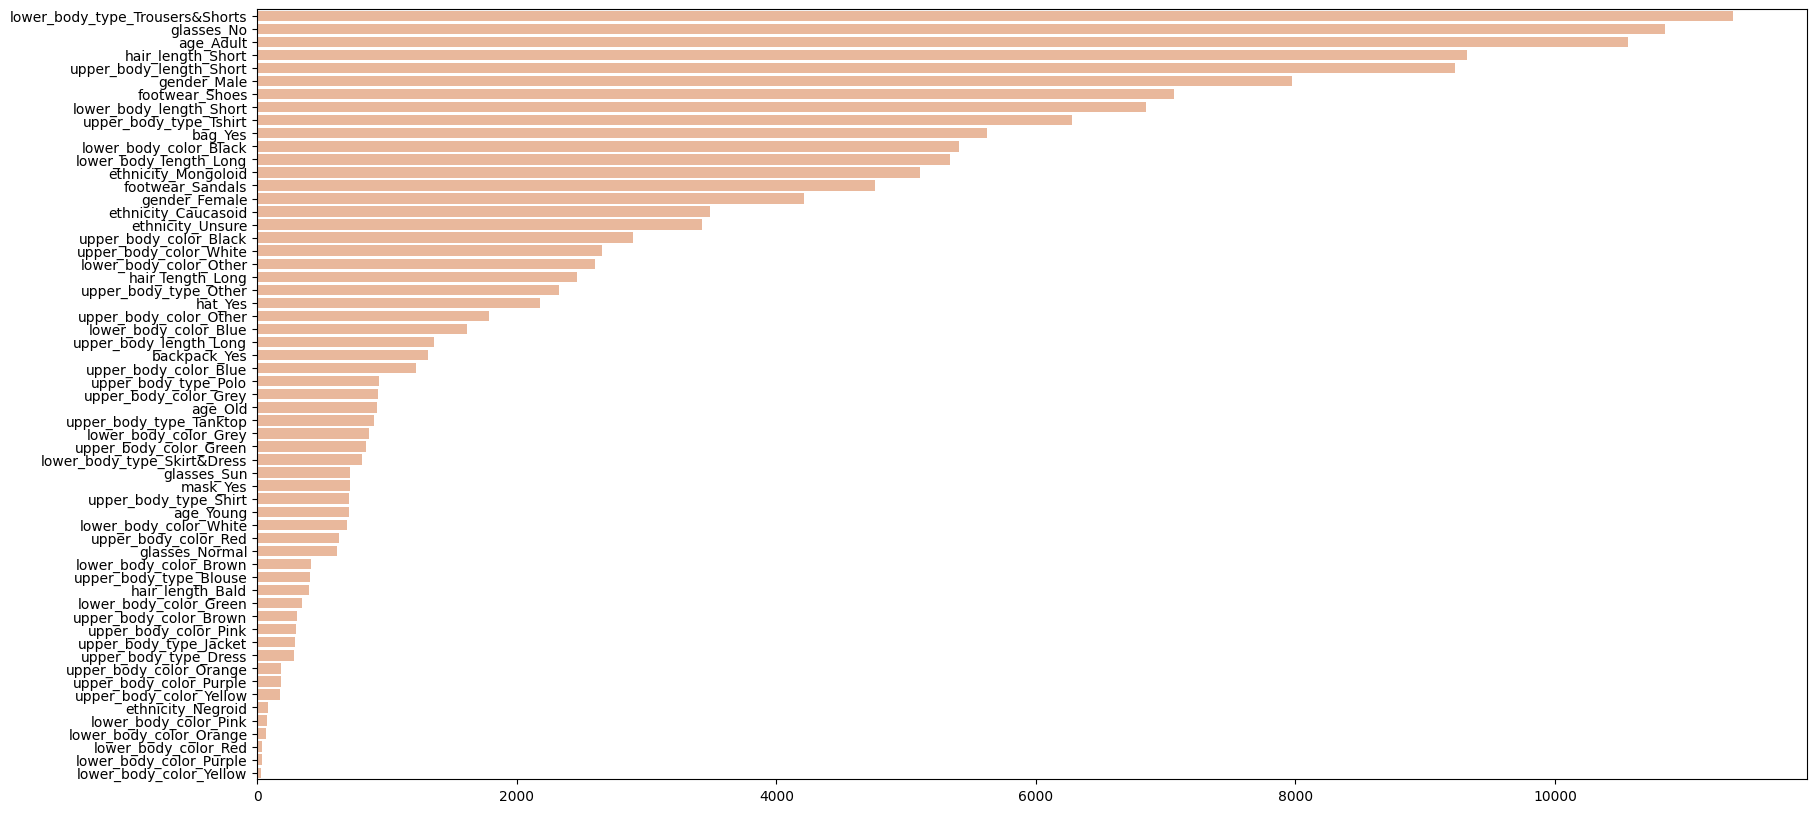

In [9]:
sns.set_palette(sns.color_palette("rocket_r"))
plt.figure(figsize=(20,10))
sns.barplot(y=counts["Label"].values, x=counts["Count"].values, order=counts["Label"].values);

In [10]:
img_ids = df_encoded.index
print('All data is {} samples'.format(len(img_ids)))
print(img_ids)

All data is 12185 samples
Index(['outdoor_group651_Ch12_CH 12_100000.avi_4.jpg',
       'outdoor_group21_Ch12_CH 12_150000.avi_2.jpg',
       'outdoor_group1628_Ch12_CH 12_090000.avi.jpg',
       'outdoor_group172_Ch12_CH 12_170358.avi.jpg',
       'outdoor_group265_Ch12_CH 12_170358.avi_1.jpg',
       'outdoor_group1027_Ch12_CH 12_170000.avi_4.jpg',
       'outdoor_group1252_Ch12_CH 12_130000.avi_2.jpg',
       'outdoor_group387_Ch12_CH 12_110000.avi.jpg',
       'outdoor_group1646_Ch12_CH 12_090000.avi_5.jpg',
       'outdoor_group822_Ch12_CH 12_170000 (1).avi_1.jpg',
       ...
       'outdoor_Ch12_CH 12_150000.avi_120_1.jpg',
       'outdoor_Ch12_CH 12_090000.avi_1265.jpg',
       'outdoor_Ch12_CH 12_123734.avi_1190.jpg',
       'outdoor_Ch12_CH 12_110000 (1).avi_1077.jpg',
       'outdoor_Ch12_CH 12_170000.avi_985.jpg',
       'outdoor_Ch12_CH 12_100000 (1).avi_636.jpg', 'indoor_image_23_564.jpg',
       'outdoor_Ch12_CH 12_090000.avi_857.jpg',
       'outdoor_Ch12_CH 12_130000.av

In [11]:
# Directory containing images
IMG_DIR: str = "/home/noeyiue/cpe/ICSEC/annotation/dataset"

# Get list of image paths in the directory
image_files = os.listdir(IMG_DIR)
image_files_lower = [img.lower() for img in image_files]  # To handle case insensitivity

# Extract the image IDs from the DataFrame index
img_ids = df_encoded.index

# Check if all image IDs are present in the directory
missing_images = [img_id for img_id in img_ids if img_id.lower() not in image_files_lower]

if not missing_images:
    print(f"All data is {len(img_ids)} samples")
    print("All image IDs are present in the directory.")
else:
    print(f"All data is {len(img_ids)} samples")
    print("Missing image IDs in the directory:")
    for missing_image in missing_images:
        print(missing_image)

All data is 12185 samples
All image IDs are present in the directory.


#### split to train, test and val

In [12]:
# Select rows where the index contains 'indoor'
test_rows = df_encoded.loc[df_encoded.index.str.contains('indoor')]
test_rows

,ethnicity_Caucasoid,ethnicity_Mongoloid,ethnicity_Negroid,ethnicity_Unsure,age_Adult,age_Old,age_Young,gender_Female,gender_Male,hair_length_Bald,...,lower_body_type_Trousers&Shorts,footwear_Sandals,footwear_Shoes,backpack_Yes,bag_Yes,glasses_No,glasses_Normal,glasses_Sun,hat_Yes,mask_Yes
image_name,,,,,,,,,,,,,,,,,,,,,
indoor_ch08_20240424105852.mp4_530.jpg,False,True,False,False,True,False,False,True,False,False,...,True,True,False,False,True,False,True,False,False,False
indoor_ch08_20240424105852.mp4_492.jpg,False,True,False,False,False,True,False,False,True,True,...,True,False,True,True,False,True,False,False,False,True
indoor_ch08_20240424105852.mp4_543.jpg,False,True,False,False,True,False,False,False,True,False,...,True,False,True,False,False,True,False,False,False,False
indoor_image_32_96.jpg,False,True,False,False,True,False,False,True,False,False,...,True,False,True,False,False,False,True,False,False,True
indoor_ch08_20240424105852.mp4_549.jpg,False,True,False,False,True,False,False,True,False,False,...,True,True,False,False,True,False,True,False,False,True
indoor_ch08_20240424105852.mp4_507.jpg,False,True,False,False,False,True,False,True,False,False,...,True,True,False,False,False,True,False,False,False,True
indoor_image_23_564.jpg,False,True,False,False,True,False,False,True,False,False,...,True,False,True,False,True,False,True,False,False,True


In [13]:
df_encoded = df_encoded.loc[~df_encoded.index.str.contains('indoor')]
df_encoded

,ethnicity_Caucasoid,ethnicity_Mongoloid,ethnicity_Negroid,ethnicity_Unsure,age_Adult,age_Old,age_Young,gender_Female,gender_Male,hair_length_Bald,...,lower_body_type_Trousers&Shorts,footwear_Sandals,footwear_Shoes,backpack_Yes,bag_Yes,glasses_No,glasses_Normal,glasses_Sun,hat_Yes,mask_Yes
image_name,,,,,,,,,,,,,,,,,,,,,
outdoor_group651_Ch12_CH 12_100000.avi_4.jpg,False,True,False,False,True,False,False,False,True,False,...,True,True,False,False,False,True,False,False,False,False
outdoor_group21_Ch12_CH 12_150000.avi_2.jpg,False,False,False,True,True,False,False,True,False,False,...,True,True,False,False,False,True,False,False,False,False
outdoor_group1628_Ch12_CH 12_090000.avi.jpg,True,False,False,False,False,False,True,True,False,False,...,True,True,False,False,True,False,True,False,False,False
outdoor_group172_Ch12_CH 12_170358.avi.jpg,False,True,False,False,True,False,False,False,True,False,...,True,True,False,False,True,True,False,False,True,False
outdoor_group265_Ch12_CH 12_170358.avi_1.jpg,False,True,False,False,True,False,False,False,True,True,...,True,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
outdoor_Ch12_CH 12_170000.avi_985.jpg,False,True,False,False,True,False,False,False,True,False,...,True,False,True,False,True,True,False,False,False,False
outdoor_Ch12_CH 12_100000 (1).avi_636.jpg,True,False,False,False,True,False,False,True,False,False,...,False,True,False,False,True,True,False,False,False,False
outdoor_Ch12_CH 12_090000.avi_857.jpg,False,True,False,False,False,True,False,True,False,False,...,True,True,False,False,False,True,False,False,False,False


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
trainval_idx, test_idx = train_test_split(range(len(df_encoded)), test_size=0.1995, random_state=42)
trainval_df = df_encoded.iloc[trainval_idx]
train_idx, val_idx = train_test_split(range(len(trainval_df)), test_size=0.125, random_state=42)
print(f"train_idx(70%) : {len(train_idx)} val_idx(10%) : {len(val_idx)} test_idx(20%) : {len(test_idx)}")

train_idx(70%) : 8529 val_idx(10%) : 1219 test_idx(20%) : 2430


In [16]:
train_data = df_encoded.iloc[train_idx]
print(f"train data : {train_data.shape}")

label_counts = train_data.iloc[:, :].sum()

counts = pd.DataFrame(
    {
        "Label": [labels[i] for i in range(len(labels))],
        "Count": label_counts.values
    }
)

# Reverse the labels dictionary to get the Class ID mapping
rev_label2id = {value: key for key, value in labels.items()}
counts["Class ID"] = [rev_label2id[label] for label in counts["Label"]]
counts = counts.set_index("Class ID")

# Sort the DataFrame by the 'Count' column in descending order
counts = counts.sort_values(by="Count", ascending=False)

# Display the DataFrame with a background gradient
counts.style.background_gradient(cmap="Reds")

train data : (8529, 59)


,Label,Count
Class ID,,
49,lower_body_type_Trousers&Shorts,7958
54,glasses_No,7648
4,age_Adult,7478
11,hair_length_Short,6530
13,upper_body_length_Short,6399
8,gender_Male,5580
51,footwear_Shoes,5059
35,lower_body_length_Short,4723
33,upper_body_type_Tshirt,4200


In [17]:
val_data = df_encoded.iloc[val_idx]
print(f"val data : {val_data.shape}")

label_counts = val_data.iloc[:, :].sum()

counts = pd.DataFrame(
    {
        "Label": [labels[i] for i in range(len(labels))],
        "Count": label_counts.values
    }
)

# Reverse the labels dictionary to get the Class ID mapping
rev_label2id = {value: key for key, value in labels.items()}
counts["Class ID"] = [rev_label2id[label] for label in counts["Label"]]
counts = counts.set_index("Class ID")

# Sort the DataFrame by the 'Count' column in descending order
counts = counts.sort_values(by="Count", ascending=False)

# Display the DataFrame with a background gradient
counts.style.background_gradient(cmap="Reds")

val data : (1219, 59)


,Label,Count
Class ID,,
49,lower_body_type_Trousers&Shorts,1141
54,glasses_No,1078
4,age_Adult,1066
11,hair_length_Short,963
13,upper_body_length_Short,913
8,gender_Male,791
51,footwear_Shoes,721
35,lower_body_length_Short,689
33,upper_body_type_Tshirt,596


In [18]:
test_data = df_encoded.iloc[test_idx]
test_data = pd.concat([test_data, test_rows])
print(f"test data : {test_data.shape}")

label_counts = test_data.iloc[:, :].sum()

counts = pd.DataFrame(
    {
        "Label": [labels[i] for i in range(len(labels))],
        "Count": label_counts.values
    }
)

# Reverse the labels dictionary to get the Class ID mapping
rev_label2id = {value: key for key, value in labels.items()}
counts["Class ID"] = [rev_label2id[label] for label in counts["Label"]]
counts = counts.set_index("Class ID")

# Sort the DataFrame by the 'Count' column in descending order
counts = counts.sort_values(by="Count", ascending=False)

# Display the DataFrame with a background gradient
counts.style.background_gradient(cmap="Reds")

test data : (2437, 59)


,Label,Count
Class ID,,
49,lower_body_type_Trousers&Shorts,2285
54,glasses_No,2186
4,age_Adult,2081
13,upper_body_length_Short,1874
11,hair_length_Short,1870
8,gender_Male,1609
51,footwear_Shoes,1415
35,lower_body_length_Short,1367
33,upper_body_type_Tshirt,1242


In [19]:
test_data.to_csv('/home/noeyiue/cpe/ICSEC/annotation/test_data.csv')

### Hyperparameters

=> DatasetConfig – A class that holds all the hyperparameters we will use for the processing of images. It contains the following information:
- Image size to use.
- Number of classes present in the dataset,
- Percentage of the training set images to use for validation.
- The mean and standard deviation to use for image normalization.
- Path to training and test set images along with the train.csv, which contains label id information for each image.

=> TrainingConfig –  A class that holds all the hyperparameters we will use for training and evaluation.  It contains the following information:
Batch size.
- Initial learning rate.
- The number of epochs to train the model.
- The number of workers to use for data loading.
- Model, optimizer & learning rate scheduler-related configurations.
- The threshold during metric calculation.
- To freeze the backbone model or not. If true, only the final classifier layer will be trained. Here, we found as the dataset domain is very different than the one the model is trained on, so we will train the entire model along with the final classification layer together from the start.

In [20]:
class DatasetConfig:
    IMAGE_SIZE: tuple = (224, 224) # (W, H)
    CHANNELS: int = 3
    NUM_CLASSES: int = 59
    VALID_PCT: float = 0.1

    # Pre-defined Mean & Std. Dev. of the Imagenet Trained model
    MEAN: tuple = (0.485, 0.456, 0.406)
    STD: tuple = (0.229, 0.224, 0.225)

    # dataset file and folder paths
    IMG_DIR: str = "/home/noeyiue/cpe/ICSEC/annotation/dataset"

class TrainingConfig:
    BATCH_SIZE: int = 32
    NUM_EPOCHS: int = 100
    INIT_LR: float = 1e-4
    NUM_WORKERS: int = os.cpu_count()
    OPTIMIZER_NAME: str = "Adam"
    WEIGHT_DECAY: float = 1e-4
    USE_SCHEDULER: bool = True
    SCHEDULER: str = "multi_step_lr"
    METRIC_THRESH: float = 0.4
    MODEL_NAME: str = "mobilenet_v3_small"
    FREEZE_BACKBONE: bool = False

### Dataset Preparation

define helper functions and one custom PyTorch Dataset class

In [21]:
def decode_target(
    target: list,
    text_labels: bool = False,
    threshold: float = 0.4,
    cls_labels: dict = None,
):
    """This function converts the labels from
    probablities to outputs or string representations
    """
 
    result = []
    for i, x in enumerate(target):
        if x >= threshold:
            if text_labels:
                result.append(cls_labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return " ".join(result)

In [22]:
def denormalize(tensors, *, mean, std):
    """Denormalizes image tensors using mean and std provided
    and clip values between 0 and 1"""
 
    for c in range(DatasetConfig.CHANNELS):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])
 
    return torch.clamp(tensors, min=0.0, max=1.0)

In [23]:
class PARDataset(Dataset):
    def __init__(self, *, df, root_dir, img_size, transforms=None, is_test=False):
        self.df = df
        self.root_dir = root_dir
        self.img_size = img_size
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.index[idx]
        img_fname = self.root_dir + os.sep + str(img_id) 

        img = Image.open(img_fname).convert("RGB")
        img = img.resize(self.img_size, resample=3)
        img = self.transforms(img)

        labels = self.df.iloc[idx, :].values.astype(np.float32)
        # if self.is_test:
        #     return img, img_id
        
        return img, labels

In [24]:
class PARDataModule(pl.LightningDataModule):
    def __init__(
        self,
        *,
        num_classes=59,
        valid_pct=0.1,
        resize_to=(224, 224),
        batch_size=32,
        num_workers=os.cpu_count(),
        pin_memory=False,
        shuffle_validation=False,
    ):
        super().__init__()
 
        self.num_classes = num_classes
        self.valid_pct = valid_pct
        self.resize_to = resize_to
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.shuffle_validation = shuffle_validation
 
        self.train_tfs = TF.Compose(
            [
                TF.RandomAffine(
                    degrees=(0, 20),
                    translate=(0.01, 0.1),
                    shear=0.05,
                ),
                TF.RandomHorizontalFlip(),
                TF.RandomVerticalFlip(),
                TF.ToTensor(),
                TF.Normalize(DatasetConfig.MEAN, DatasetConfig.STD, inplace=True),
                TF.RandomErasing(inplace=True, ratio=(0.3, 1.0)),
            ]
        )
       
 
        self.valid_tfs = TF.Compose(
            [
                TF.ToTensor(),
                TF.Normalize(DatasetConfig.MEAN, DatasetConfig.STD, inplace=True),
            ]
        )
        self.test_tfs = self.valid_tfs
 
 
    def setup(self, stage=None):
        np.random.seed(42)
        msk = np.random.rand(len(train_data)) < (1.0 - self.valid_pct)
        train_df = train_data
        valid_df = val_data
        test_df = test_data

        img_size = DatasetConfig.IMAGE_SIZE
        self.train_ds = PARDataset(
            df=train_df, img_size=img_size, root_dir=DatasetConfig.IMG_DIR, transforms=self.train_tfs
        )

        self.valid_ds = PARDataset(
            df=valid_df, img_size=img_size, root_dir=DatasetConfig.IMG_DIR, transforms=self.valid_tfs
        )
 
        self.test_ds = PARDataset(
            df=test_df, img_size=img_size, root_dir=DatasetConfig.IMG_DIR, transforms=self.test_tfs, is_test=True
        )
 
        print(f"Number of images :: Training: {len(self.train_ds)}, Validation: {len(self.valid_ds)}, Testing: {len(self.test_ds)}\n")
        # print(f"Number of images :: Training: {len(self.train_ds)}, Validation: {len(self.valid_ds)}\n")
 
    def train_dataloader(self):
        # Create a train dataloader.
        train_loader = DataLoader(
            self.train_ds, batch_size=self.batch_size, pin_memory=self.pin_memory, shuffle=True, num_workers=self.num_workers
        )
        return train_loader
 
    def val_dataloader(self):
        # Create validation dataloader object.
        valid_loader = DataLoader(
            self.valid_ds, batch_size=self.batch_size, pin_memory=self.pin_memory, 
            shuffle=self.shuffle_validation, num_workers=self.num_workers
        )
        return valid_loader
 
    def test_dataloader(self):
        # Create test dataloader object.
        test_loader = DataLoader(
            self.test_ds, batch_size=self.batch_size, pin_memory=self.pin_memory, shuffle=False, num_workers=self.num_workers
        )
        return test_loader

Load Pretrained Models From Torchvision

In [25]:
def get_model(model_name: str, num_classes: int, freeze_backbone: bool= True):
    """A helper function to load and prepare any classification model 
    available in Torchvision for transfer learning or fine-tuning."""
     
    model = getattr(torchvision.models, model_name)(weights="DEFAULT")
     
    if freeze_backbone:
        # Set all layer to be non-trainable
        for param in model.parameters():
            param.requires_grad = False
         
    model_childrens = [name for name, _ in model.named_children()]
 
    try:
        final_layer_in_features = getattr(model, f"{model_childrens[-1]}")[-1].in_features
    except Exception as e:
        final_layer_in_features = getattr(model, f"{model_childrens[-1]}").in_features
 
    new_output_layer = nn.Linear(
        in_features=final_layer_in_features, 
        out_features=num_classes
    )
     
    try:
        getattr(model, f"{model_childrens[-1]}")[-1] = new_output_layer
    except:
        setattr(model, model_childrens[-1], new_output_layer)
     
    return model

In [26]:
model = get_model(
    model_name=TrainingConfig.MODEL_NAME, 
    num_classes=DatasetConfig.NUM_CLASSES,
    freeze_backbone=False,
)
 
summary(
    model, 
    input_size=(1, DatasetConfig.CHANNELS, *DatasetConfig.IMAGE_SIZE[::-1]), 
    depth=2, 
    device="cpu", 
    col_names=["output_size", "num_params", "trainable"]
)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/noeyiue/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████████████████████████████████| 9.83M/9.83M [00:01<00:00, 8.99MB/s]


Layer (type:depth-idx)                             Output Shape              Param #                   Trainable
MobileNetV3                                        [1, 59]                   --                        True
├─Sequential: 1-1                                  [1, 576, 7, 7]            --                        True
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         464                       True
│    └─InvertedResidual: 2-2                       [1, 16, 56, 56]           744                       True
│    └─InvertedResidual: 2-3                       [1, 24, 28, 28]           3,864                     True
│    └─InvertedResidual: 2-4                       [1, 24, 28, 28]           5,416                     True
│    └─InvertedResidual: 2-5                       [1, 40, 14, 14]           13,736                    True
│    └─InvertedResidual: 2-6                       [1, 40, 14, 14]           57,264                    True
│    └─InvertedResidual

In [27]:
class PARModel(pl.LightningModule):
    def __init__(
        self,
        model_name: str,
        num_classes: int = 59,
        freeze_backbone: bool = False,
        init_lr: float = 1e-4,
        optimizer_name: str = "Adam",
        weight_decay: float = 1e-4,
        use_scheduler: bool = False,
        f1_metric_threshold: float = 0.4,
        metrics_file_path: str = "metrics.json",
        dropout_prob: float = 0.3
    ):
        super().__init__()

        # Save the arguments as hyperparameters.
        self.save_hyperparameters()

        # Loading model using the function defined above.
        self.model = get_model(
            model_name=self.hparams.model_name,
            num_classes=self.hparams.num_classes,
            freeze_backbone=self.hparams.freeze_backbone,
        )
        self.dropout = nn.Dropout(p=self.hparams.dropout_prob)

        # Initialize loss class.
        self.loss_fn = nn.BCEWithLogitsLoss()

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_f1 = MultilabelF1Score(num_labels=self.hparams.num_classes, 
                                               average="macro", threshold=self.hparams.f1_metric_threshold)
        self.train_mA = MultilabelAccuracy(num_labels=self.hparams.num_classes, 
                                               average="macro", threshold=self.hparams.f1_metric_threshold)
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_f1 = MultilabelF1Score(num_labels=self.hparams.num_classes, 
                                               average="macro", threshold=self.hparams.f1_metric_threshold)
        self.valid_mA = MultilabelAccuracy(num_labels=self.hparams.num_classes, 
                                               average="macro", threshold=self.hparams.f1_metric_threshold)

        self.metrics_file_path = metrics_file_path
        

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, *args, **kwargs):
        data, target = batch
        logits = self(data)
        loss = self.loss_fn(logits, target)
    
        # Update metric states
        self.mean_train_loss(loss, weight=data.shape[0])
        self.mean_train_f1(logits, target)
        self.train_mA(logits, target)
    
        # Log metrics
        self.log("train/batch_loss", self.mean_train_loss, prog_bar=True)
        self.log("train/batch_f1", self.mean_train_f1, prog_bar=True)
        self.log("train/batch_mA", self.train_mA, prog_bar=True)
    
        return loss

    def on_train_epoch_end(self):
        # Computing and logging the training mean loss & mean f1.
        self.log("train/loss", self.mean_train_loss, prog_bar=True)
        self.log("train/f1", self.mean_train_f1, prog_bar=True)
        self.log("train/mA", self.train_mA, prog_bar=True)
        self.log("step", self.current_epoch)
        self.save_metrics()

    def validation_step(self, batch, *args, **kwargs):
        data, target = batch
        logits = self(data)
        loss = self.loss_fn(logits, target)

        self.mean_valid_loss.update(loss, weight=data.shape[0])
        self.mean_valid_f1.update(logits, target)
        self.valid_mA.update(logits, target)

    def on_validation_epoch_end(self):
        # Computing and logging the validation mean loss & mean f1.
        self.log("valid/loss", self.mean_valid_loss, prog_bar=True)
        self.log("valid/f1", self.mean_valid_f1, prog_bar=True)
        self.log("valid/mA", self.valid_mA, prog_bar=True)
        self.log("step", self.current_epoch)
        self.save_metrics()

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.hparams.optimizer_name)(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=self.hparams.init_lr,
            weight_decay=self.hparams.weight_decay,
        )
 
        if self.hparams.use_scheduler:
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[self.trainer.max_epochs // 3,],
                gamma=0.1,
            )
 
            # The lr_scheduler_config is a dictionary that contains the scheduler
            # and its associated configuration.
            lr_scheduler_config = {
                "scheduler": lr_scheduler,
                "interval": "epoch",
                "name": "multi_step_lr",
            }
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_config}
 
        else:
            return optimizer

    def save_metrics(self):
        metrics = {
            "epoch": self.current_epoch,
            "train_loss": self.mean_train_loss.compute().item(),
            "train_f1": self.mean_train_f1.compute().item(),
            "train_mA": self.train_mA.compute().item(),
            "valid_loss": self.mean_valid_loss.compute().item(),
            "valid_f1": self.mean_valid_f1.compute().item(),
            "valid_mA": self.valid_mA.compute().item()
        }
        with open(self.metrics_file_path, "a") as f:
            json.dump(metrics, f)
            f.write("\n")


In [28]:
pl.seed_everything(42, workers=True)
metrics_file_path = "./metrics.json"

# Check if metrics file exists
if os.path.exists(metrics_file_path):
    # Delete the existing metrics file
    os.remove(metrics_file_path)

# Create a new metrics file (empty for initialization)
with open(metrics_file_path, 'w') as f:
    f.write('{}')  # Write empty JSON object
    
model = PARModel(
    model_name=TrainingConfig.MODEL_NAME,
    num_classes=DatasetConfig.NUM_CLASSES,
    freeze_backbone=TrainingConfig.FREEZE_BACKBONE,
    init_lr=TrainingConfig.INIT_LR,
    optimizer_name=TrainingConfig.OPTIMIZER_NAME,
    weight_decay=TrainingConfig.WEIGHT_DECAY,
    use_scheduler=TrainingConfig.USE_SCHEDULER,
    f1_metric_threshold=TrainingConfig.METRIC_THRESH,
    metrics_file_path=metrics_file_path,
    dropout_prob = 0.3,
)

data_module = PARDataModule(
    num_classes=DatasetConfig.NUM_CLASSES,
    valid_pct=DatasetConfig.VALID_PCT,
    resize_to=DatasetConfig.IMAGE_SIZE,
    batch_size=TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)

Global seed set to 42


### Train

In [29]:
# Creating ModelCheckpoint callback.
# Checkpoints by default will be saved in Trainer - default_root_dir which is "lightning_logs".
# Set the path where you want to save checkpoints
checkpoint_path = "/home/noeyiue/cpe/ICSEC/PAR/mobilenet_v3_small/lightning_logs/"

# Creating ModelCheckpoint callback.
model_checkpoint = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="ckpt_{epoch:03d}-vloss_{valid/loss:.4f}_vf1_{valid/f1:.4f}",
    monitor="valid/f1",
    mode="max",
    auto_insert_metric_name=False,
)
model_checkpoint = ModelCheckpoint(
    dirpath=checkpoint_path,
    monitor="valid/f1",
    mode="max",
    filename="ckpt_{epoch:03d}-vloss_{valid/loss:.4f}_vf1_{valid/f1:.4f}", 
    auto_insert_metric_name=False,
)
 
# Creating a learning rate monitor callback which will be plotted/added in the default logger.
lr_rate_monitor = LearningRateMonitor(logging_interval="epoch")

early_stop_callback = EarlyStopping(
    monitor="valid/loss",
    mode="min",
    patience=5,
    verbose=True
)

# Initializing the Trainer class object.
# It uses 'Tensorboard' as its default logger.
trainer = pl.Trainer(
    accelerator="auto", # Auto select the best hardware accelerator available
    devices="auto", # Auto select available devices for the accelerator (For eg. mutiple GPUs)
    strategy="auto", # Auto select the distributed training strategy.
    max_epochs=TrainingConfig.NUM_EPOCHS, # Maximum number of epoch to train for.
    deterministic=True, # For deteministic and reproducible training.
    enable_model_summary=False, # Disable printing of model summary as we are using torchinfo.
    callbacks=[model_checkpoint, lr_rate_monitor, early_stop_callback],
    precision="16-mixed", # Using Mixed Precision training.
    logger=True, # Auto generate TensorBoard logs.
)
 
# Start training
trainer.fit(model, data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/noeyiue/cpe/ICSEC/PAR/mobilenet_v3_small/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of images :: Training: 8529, Validation: 1219, Testing: 2437



2024-06-27 00:01:19.199990: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 00:01:19.222091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 00:01:19.222112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 00:01:19.222127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 00:01:19.226715: I tensorflow/core/platform/cpu_feature_g

Sanity Checking: 0it [00:00, ?it/s]

/home/noeyiue/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/noeyiue/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanMetric was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/noeyiue/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MultilabelF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/noeyiue/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWar

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/noeyiue/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
Metric valid/loss improved. New best score: 0.296


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.037 >= min_delta = 0.0. New best score: 0.260


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.017 >= min_delta = 0.0. New best score: 0.242


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.013 >= min_delta = 0.0. New best score: 0.230


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.220


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.213


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.208


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.202


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.197


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.195


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.192


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.189


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.183


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.182


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.178


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.177


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.177


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.172


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.171


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.166


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.165


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.164


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.161


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.161


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.159


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.158


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.155


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.152


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.152


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.151


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.148


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.008 >= min_delta = 0.0. New best score: 0.140


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.139


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.138


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.138


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.138


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.137


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.137


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.137


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.136


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.136


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.136


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.136


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.136


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.135


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.135


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.134


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.134


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.133


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.133


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.133


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.133


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.133


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.133


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.132


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.132


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.132


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.132


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.131


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.131


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.131


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.130


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric valid/loss did not improve in the last 5 records. Best score: 0.130. Signaling Trainer to stop.


In [30]:
# Get path of the best saved model.
CKPT_PATH = model_checkpoint.best_model_path
model = PARModel.load_from_checkpoint(CKPT_PATH)

In [31]:
# Initialize trainer class for inference.
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,        
    enable_checkpointing=False,
    inference_mode=True,
)
 
# Run evaluation.
data_module.setup()
valid_loader = data_module.val_dataloader()
trainer.validate(model=model, dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of images :: Training: 8529, Validation: 1219, Testing: 2437



Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           step            │            0.0            │
│         valid/f1          │    0.7374913692474365     │
│        valid/loss         │    0.13101732730865479    │
│         valid/mA          │    0.9462882280349731     │
└───────────────────────────┴───────────────────────────┘

[{'valid/loss': 0.13101732730865479,
  'valid/f1': 0.7374913692474365,
  'valid/mA': 0.9462882280349731,
  'step': 0.0}]

In [32]:
best_model = PARModel.load_from_checkpoint(
    checkpoint_path=CKPT_PATH,
    model_name=TrainingConfig.MODEL_NAME,
    num_classes=DatasetConfig.NUM_CLASSES,
    freeze_backbone=TrainingConfig.FREEZE_BACKBONE,
    init_lr=TrainingConfig.INIT_LR,
    optimizer_name=TrainingConfig.OPTIMIZER_NAME,
    weight_decay=TrainingConfig.WEIGHT_DECAY,
    use_scheduler=TrainingConfig.USE_SCHEDULER,
    f1_metric_threshold=TrainingConfig.METRIC_THRESH, 
)

In [33]:
# Save the model's state dict
# torch.save(best_model.state_dict(), 'best_model_state_dict.pth')

# Alternatively, save the entire model
torch.save(best_model, 'mobilenet_v3_small_1.pth')

### Eval val

In [34]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model_path = "./mobilenet_v3_small_1.pth"

model = torch.load(model_path, map_location=DEVICE)
model.to(DEVICE)
model.eval()

# Initialize trainer class for inference.
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,        
    enable_checkpointing=False,
    inference_mode=True,
)
 
# Run evaluation.
data_module.setup()
valid_loader = data_module.val_dataloader()
trainer.validate(model=model, dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of images :: Training: 8529, Validation: 1219, Testing: 2437



Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           step            │            0.0            │
│         valid/f1          │    0.7374913692474365     │
│        valid/loss         │    0.13101732730865479    │
│         valid/mA          │    0.9462882280349731     │
└───────────────────────────┴───────────────────────────┘

[{'valid/loss': 0.13101732730865479,
  'valid/f1': 0.7374913692474365,
  'valid/mA': 0.9462882280349731,
  'step': 0.0}]

In [35]:
from playsound import playsound
from pynput import keyboard

# Flag to control the playback loop
stop_playback = False

def on_press(key):
    global stop_playback
    stop_playback = True
    return False  # Stop listener

# Function to play the sound repeatedly until a key is pressed
def play_sound_until_key_pressed(sound_file):
    global stop_playback
    while not stop_playback:
        playsound(sound_file)

# Specify the sound file path
sound_file = 'success-48018.mp3'

# Set up the key listener in a separate thread
listener = keyboard.Listener(on_press=on_press)
listener.start()

# Call the function to play the sound until a key is pressed
play_sound_until_key_pressed(sound_file)

print('Key pressed. Exiting...')


Key pressed. Exiting...
